In [1]:
import numpy
import cv2

In [2]:
from scipy.ndimage import gaussian_laplace

#Enhance Skin Texture (Pores and Wrinkles)
def enhance_skin_texture(image):
    # Apply a Laplacian of Gaussian (LoG) filter to detect fine details
    log_image = gaussian_laplace(image, sigma=1)
    
    # Optionally, apply contrast enhancement
    enhanced_image = cv2.normalize(log_image, None, 0, 255, cv2.NORM_MINMAX)
    
    return enhanced_image

In [3]:
# Step 1: Preprocess the Image
def preprocess_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (128, 128))  # Resize for consistency
    return image

In [4]:
image = preprocess_image("C:/Users/sadik/OneDrive/Desktop/Liveness detection/dataset/Live/Train/26.jpg")
enhanced_image = enhance_skin_texture(image)
# print(enhanced_image)

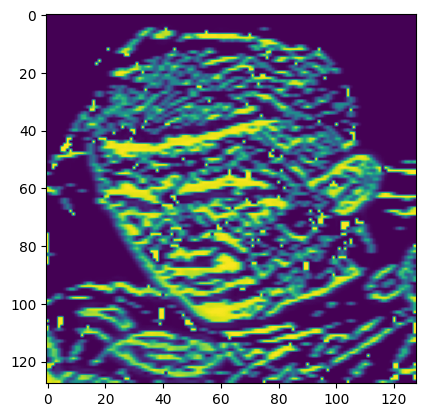

In [5]:
import matplotlib.pyplot as plt
plt.imshow(enhanced_image)

In [6]:
# Extract features
def extract_skin_features(image_path):
    image = preprocess_image(image_path)
    features = enhance_skin_texture(image)
    return features

In [7]:
import os 
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.svm import SVC

In [8]:
folder_path = 'C:/Users/sadik/OneDrive/Desktop/Liveness detection/dataset'

In [9]:
def load_dataset(folder_path, label):
    feature_list = []
    labels=[]
    
    for image_file in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image_file)
        features = extract_skin_features(image_path)
        feature_list.append(features)
        labels.append(label)
    
    return np.array(feature_list), np.array(labels)

In [10]:
live_train_path = 'C:/Users/sadik/OneDrive/Desktop/Liveness detection/dataset/Live/Train'
live_test_path = 'C:/Users/sadik/OneDrive/Desktop/Liveness detection/dataset/Live/Test'
spoof_train_path = 'C:/Users/sadik/OneDrive/Desktop/Liveness detection/dataset/Spoof/Train'
spoof_test_path = 'C:/Users/sadik/OneDrive/Desktop/Liveness detection/dataset/Spoof/Test'

In [11]:
#Extract feature for both live and spoof dataset 
X_live_train,y_live_train = load_dataset(live_train_path, label=1)
X_spoof_train, y_spoof_train = load_dataset(spoof_train_path,label=0)
X_live_test, y_live_test = load_dataset(live_test_path,label=1)
X_spoof_test, y_spoof_test = load_dataset(spoof_test_path,label=0)

In [12]:
# Combine the live and spoof training data
X_train = np.vstack((X_live_train, X_spoof_train))
y_train = np.concatenate((y_live_train, y_spoof_train), axis=0)

# Combine the live and spoof testing data
X_test = np.vstack((X_live_test, X_spoof_test))
y_test = np.concatenate((y_live_test, y_spoof_test), axis=0)

In [13]:
# If X_train is 3D, flatten it to 2D
if X_train.ndim == 3:
    X_train = X_train.reshape(X_train.shape[0], -1)

# Similarly, flatten X_test if it is 3D
if X_test.ndim == 3:
    X_test = X_test.reshape(X_test.shape[0], -1)
    
    
#Scale the features using StandardScaler    
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)


In [14]:
# Check shapes to confirm consistency
print("Combined Train Shape:", X_train.shape, y_train.shape)

Combined Train Shape: (480, 16384) (480,)


In [15]:
svc = SVC(kernel='rbf', C=1.0, random_state=42)  
svc.fit(X_train_scaled, y_train)

SVC(random_state=42)

In [ ]:
import joblib
import sys
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from collections import Counter


class_counts = Counter(y_train)
sys.modules['sklearn.externals.joblib']=joblib
n_splits = min(class_counts.values())
forward_fs_best=sfs(estimator=svc,k_features='best',forward=True,verbose=1,scoring='accuracy',cv=2)


sfs_forward_best=forward_fs_best.fit(X_train_scaled,y_train)


In [ ]:
print('R-Squared value:', sfs_forward_best.k_score_)



In [16]:
# Predict on the test data
y_pred = svc.predict(X_test_scaled)

In [17]:
# Determine the unique labels in y_test
unique_labels = np.unique(y_test)

# Generate the confusion matrix with the appropriate labels
conf_matrix = confusion_matrix(y_test, y_pred, labels=unique_labels)

# Handle cases where unique_labels may not contain both 0 and 1
TP = conf_matrix[0][0] if 1 in unique_labels else 0
FN = conf_matrix[0][1] if 1 in unique_labels and len(unique_labels) > 1 else 0
FP = conf_matrix[1][0] if 0 in unique_labels and len(unique_labels) > 1 else 0
TN = conf_matrix[1][1] if 0 in unique_labels else 0

# Print the results
print("True Positive:", TP)
print("False Negative:", FN)
print("False Positive:", FP)
print("True Negative:", TN)
print("Accuracy of the SVM:", accuracy_score(y_test, y_pred))
print("Precision of the SVM:", precision_score(y_test, y_pred, pos_label=1) if 1 in unique_labels else 'N/A')
print("Recall of the SVM:", recall_score(y_test, y_pred, pos_label=1) if 1 in unique_labels else 'N/A')


True Positive: 41
False Negative: 19
False Positive: 1
True Negative: 59
Accuracy of the SVM: 0.8333333333333334
Precision of the SVM: 0.7564102564102564
Recall of the SVM: 0.9833333333333333
